In [9]:
from pathlib import Path
import tensorflow as tf, pickle
import datetime as dt
from datetime import datetime

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt   
import numpy as np

import stockanalibs

In [11]:
ticker = stockanalibs.ticker

today     = datetime.now().strftime("%Y-%m-%d")

# ── 1 · load model (architecture + weights already inside) ────────────
save_dir   = Path("dfs training")
file_path = save_dir / f"{ticker}_{today}_model.keras"
model      = tf.keras.models.load_model(file_path)

# (optional) re-load weights-only checkpoint in case you updated it
ckpt_path  = save_dir / f"{ticker}_{today}.weights.h5"
model.load_weights(ckpt_path)      # harmless if identical

# ── 2 · load tf.data test set exactly as it was saved ─────────────────

ds_test = tf.data.Dataset.load(str(save_dir / f"{ticker}_ds_test.pkl"), compression="GZIP")



In [12]:
# ── 3 · evaluate RMSE day-by-day (stateful, 1-bar horizon) ────────────
lstm_layers = [l for l in model.layers if hasattr(l, "reset_states")]
test_metric = tf.keras.metrics.RootMeanSquaredError(name="rmse")

N_test = sum(1 for _ in ds_test)          # concrete length for tqdm
ds_test = ds_test.cache()                 # keep in RAM/GPU

for X_day, y_day, _ in tqdm(ds_test, total=N_test, unit="day", desc="Testing"):
    for l in lstm_layers: l.reset_states()

    y_pred = model(X_day, training=False)         # shape (1, T, 1)
    y_pred = tf.squeeze(y_pred, (0, 2))           #  → (T,)

    # align: compare ŷ(t) with y(t+1)
    y_true = tf.squeeze(y_day)                    # (T,)
    test_metric.update_state(y_true[1:], y_pred[:-1])

print(f"\nFINAL OOS TEST RMSE (1-bar ahead) = {test_metric.result():.5f}")


Testing:   0%|          | 0/423 [00:00<?, ?day/s]


FINAL OOS TEST RMSE (1-bar ahead) = 0.20017


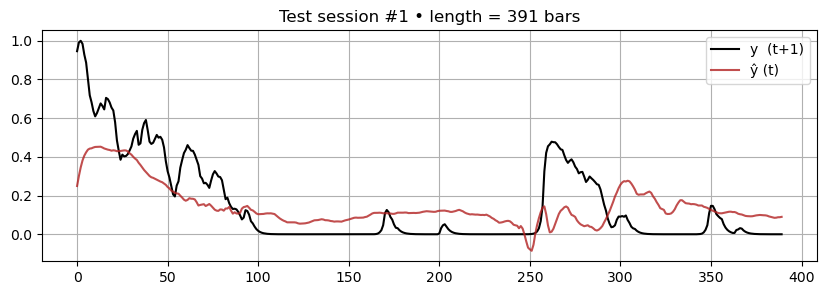

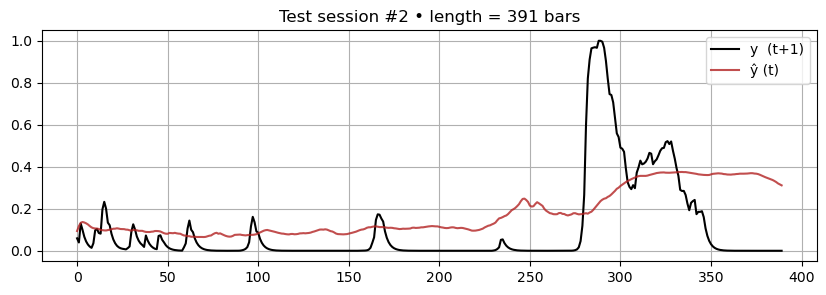

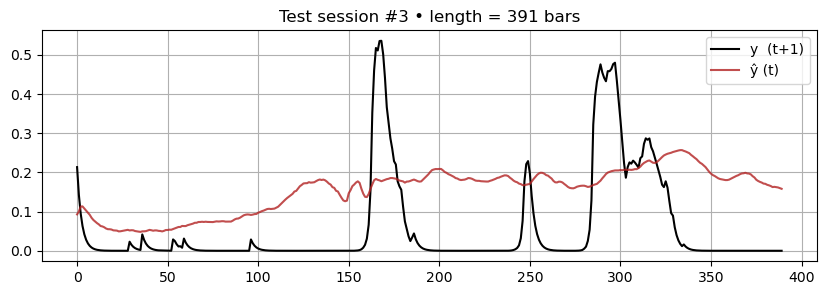

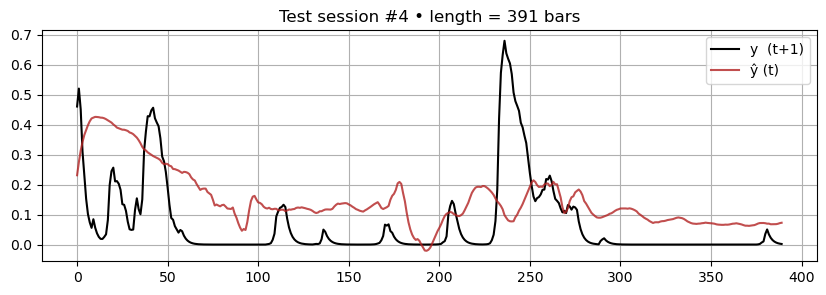

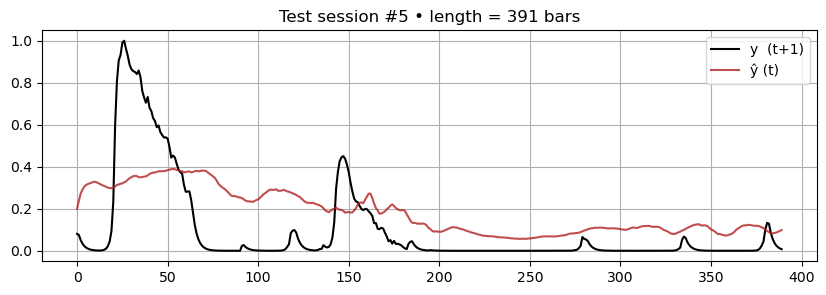

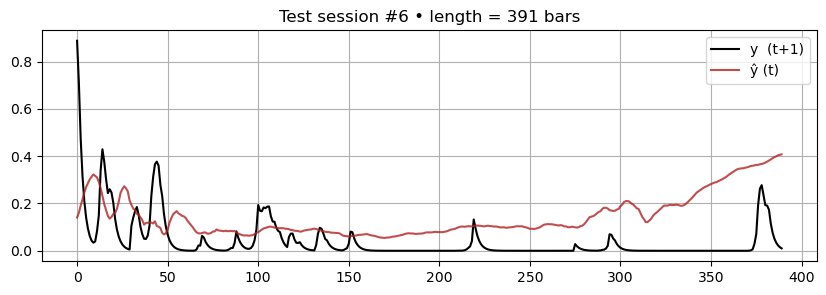

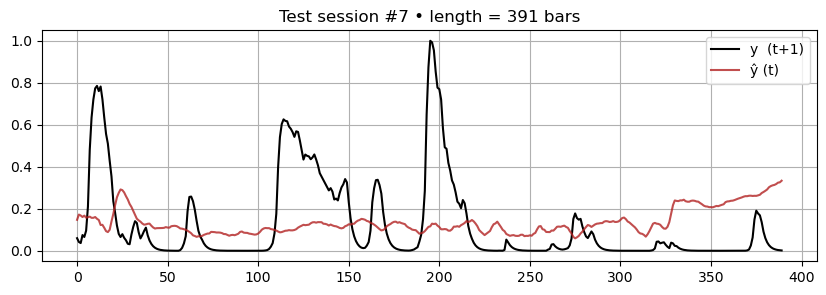

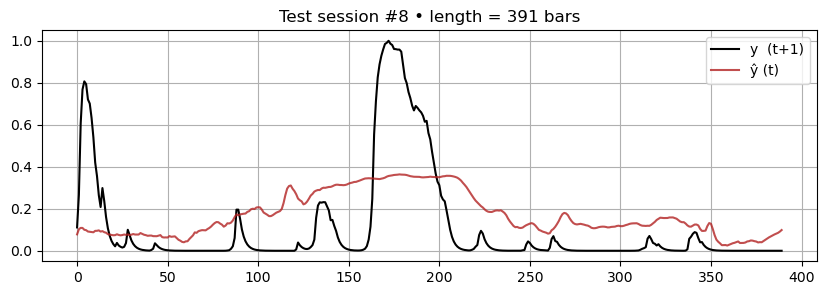

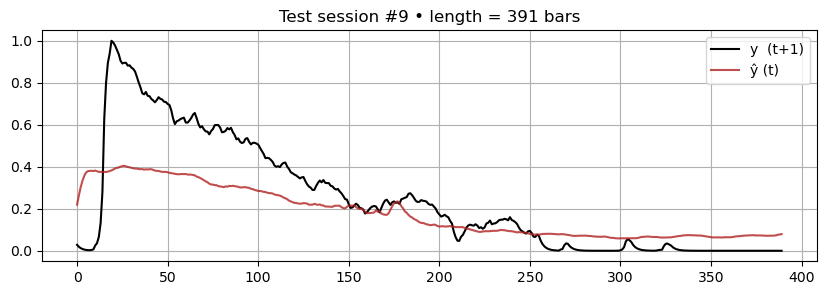

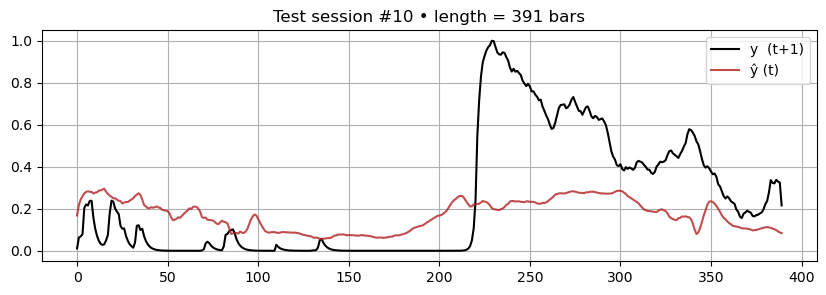

In [13]:
# ── 4 · quick visual sanity check ─────────────────────────────────────
N_PLOTS, plotted = 10, 0

for X_day, y_day, _ in ds_test:
    for l in lstm_layers: l.reset_states()

    y_hat  = model(X_day, training=False).numpy().squeeze()   # (T,)
    y_true = y_day.numpy().squeeze()                          # (T,)

    shift = 1                             # horizon in bars
    plt.figure(figsize=(10, 3))
    plt.plot(y_true[shift:],            label="y  (t+1)", color="black")
    plt.plot(y_hat[:-shift], alpha=.8,  label="ŷ (t)",   color="firebrick")
    plt.title(f"Test session #{plotted+1} • length = {len(y_true)} bars")
    plt.legend(); plt.grid(True); plt.show()

    plotted += 1
    if plotted >= N_PLOTS:
        break


In [8]:
# # to confirm the shift of the prediction above (we are predicting the next signal, so we need to align it with the label for visualization)

# corr_curr = np.corrcoef(y_true,         y_hat        )[0,1]
# corr_lag1 = np.corrcoef(y_true[:-1],    y_hat[1:]    )[0,1]  # ŷ leads by 1
# corr_lag_1 = np.corrcoef(y_true[1:],    y_hat[:-1]   )[0,1]  # ŷ lags  by 1

# print(f"zero-lag   : {corr_curr:6.3f}")
# print(f"ŷ leads 1 : {corr_lag1:6.3f}")
# print(f"ŷ lags 1  : {corr_lag_1:6.3f}")


# rmse_curr = np.sqrt(np.mean((y_true      - y_hat)      ** 2))
# rmse_lead = np.sqrt(np.mean((y_true[:-1] - y_hat[1:]) ** 2))

# print("RMSE  curr :", rmse_curr)
# print("RMSE  lead :", rmse_lead)


zero-lag   :  0.298
ŷ leads 1 :  0.306
ŷ lags 1  :  0.294
RMSE  curr : 0.29140922
RMSE  lead : 0.29122308
